# Chronos Fine-Tuning on financial time series data

This notebook is designed to fine-tune and evaluate the performance of the Chronos forecasting model on financial time series data.
It begins by installing necessary dependencies and downloading historical stock data using Yahoo Finance.
The data is then converted to the Arrow format for efficient processing, as requested by Chronos.

The notebook sets up a configuration for training the Chronos model, including parameters like learning rate and maximum steps.
It trains the model using the specified configuration
and evaluates its performance by comparing the fine-tuned model's predictions
against a zero-shot model (pre-trained without fine-tuning).

The evaluation includes calculating various metrics such as MSE, RMSE, MAPE, and MASE,
and visualizing the forecast results to compare the performance of the fine-tuned model against the zero-shot model.

#### Install Dependencies

In [ ]:
!pip install yfinance

# Clone the Chronos repository and install training dependencies
!git clone https://github.com/amazon-science/chronos-forecasting.git
%cd chronos-forecasting
!pip install -e .[training]
%cd ..

# Install Chronos
!pip install git+https://github.com/amazon-science/chronos-forecasting.git

In [2]:
import torch
import numpy as np
import pandas as pd
import yfinance as yf
from pathlib import Path
from typing import List, Union
import matplotlib.pyplot as plt
from gluonts.dataset.arrow import ArrowWriter
from chronos import BaseChronosPipeline, ChronosPipeline

In [3]:
tickers = ["AAPL"]
time_series_list = []

for ticker in tickers:
    df = yf.download(ticker, start="2013-01-01", end="2023-01-01")
    time_series_list.append(df["Close"].values.flatten())

[*********************100%***********************]  1 of 1 completed


In [4]:
def convert_to_arrow(
        path: Union[str, Path],
        time_series: Union[List[np.ndarray], np.ndarray],
        compression: str = "lz4",
):
    """
    Save a set of time series in Arrow format at the specified path.
    Each time series is flattened to ensure it is saved as a 1D array.
    """

    # Set an arbitrary start time
    start = np.datetime64("2000-01-01 00:00", "s")

    # For each time series, ensure it is a 1D array
    dataset = [{ "start": start, "target": np.array(ts).flatten() } for ts in time_series]

    ArrowWriter(compression=compression).write_to_file(dataset, path=path)
    print(f"File Arrow saved in: {path}")

In [5]:
# Save the data to /content/stock_data.arrow
convert_to_arrow("/content/stock_data.arrow", time_series=time_series_list)

File Arrow saved in: /content/stock_data.arrow


## Fine-Tuning Chronos

#### Fine-Tuning Configuration

In [6]:
%%writefile /content/config.yaml
training_data_paths:
- "/content/stock_data.arrow"
probability:
- 1.0

model_id: "amazon/chronos-t5-tiny"
random_init: false

max_steps: 1000
learning_rate: 0.001

shuffle_buffer_length: 1000
torch_compile: false

Writing /content/config.yaml


#### Chronos Fine-Tuning

In [7]:
# Fine-tune
!CUDA_VISIBLE_DEVICES=0 python chronos-forecasting/scripts/training/train.py --config /content/config.yaml

# Move result and zip folder
!mv "output/run-0/checkpoint-final" "finetuned_model"
!rm -r output
!zip -r finetuned_model.zip finetuned_model

2025-02-05 23:00:02.052530: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1738796402.075904    1106 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1738796402.083147    1106 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-05 23:00:06,892 - /content/chronos-forecasting/scripts/training/train.py - INFO - TF32 format is only available on devices with compute capability >= 8. Setting tf32 to False.
2025-02-05 23:00:06,892 - /content/chronos-forecasting/scripts/training/train.py - INFO - Using SEED: 1354343147
2025-02-05 23:00:06,901 - /content/chronos-forecasting/scripts/training/train.py - INFO - Logging dir: output/run-0
2025-02-05 23:00:06,901 

### Comparison between Zero-Shot and Fine-Tuned Models

In [9]:
from scipy.stats import gmean
from sklearn.metrics import mean_squared_error, mean_absolute_error

seed = 343126  # Seed for reproducibility
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)
np.random.seed(seed)


def get_forecast_stats(forecast_tensor):
    """ Compute mean, confidence interval, and variance for the forecast """
    low, median, high = np.quantile(forecast_tensor.numpy(), [0.1, 0.5, 0.9], axis=0)
    mean_forecast = np.mean(forecast_tensor.numpy(), axis=0)
    variance_forecast = np.var(forecast_tensor.numpy(), axis=0)
    return low, median, high, mean_forecast, variance_forecast


# Evaluation metrics
def mase(y_true, y_pred, y_train):
    """
    Compute the Mean Absolute Scaled Error (MASE)
    y_true: true values
    y_pred: predicted values
    y_train: historical series to calculate the naive benchmark
    """
    naive_forecast = np.abs(np.diff(y_train)).mean()  # Naive Model: mean differences between successive values
    return np.mean(np.abs(y_true - y_pred)) / naive_forecast


def compute_metrics(y_true, y_pred, y_train):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    mase_score = mase(y_true, y_pred, y_train)
    return { "MSE": mse, "RMSE": rmse, "MAPE": mape, "MASE": mase_score }


def agg_relative_score(model_df: pd.DataFrame, baseline_df: pd.DataFrame):
    relative_score = model_df / baseline_df  # Ratio between model and baseline
    return relative_score.agg(gmean)  # Geometric mean of improvements

----------- AAPL -----------
Variance (Zero-Shot): [12.5715885 26.225292  29.660498  27.481693  30.640924  31.926413
 42.551613  58.50756   70.962906  89.068596 ]
Variance (Fine-Tuned): [14.953694 12.048619 11.649161 13.479332 22.739159 26.145285 24.075472
 15.687195 11.177121 13.653666]


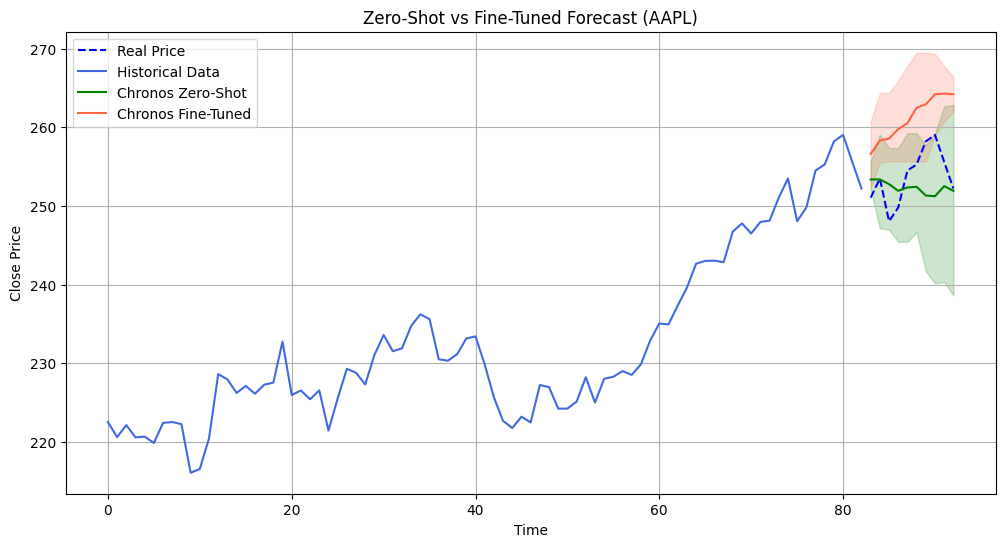

<ipython-input-9-8a243eab4cfa>:41: FutureWarning: using <function gmean at 0x7f306e7996c0> in Series.agg cannot aggregate and has been deprecated. Use Series.transform to keep behavior unchanged.
  return relative_score.agg(gmean)  # Geometric mean of improvements



PERFORMANCE METRICS:
                          MSE      RMSE      MAPE      MASE
Chronos Zero-Shot   13.110134  3.620792  1.213177  1.571628
Chronos Fine-Tuned  58.093125  7.621885  2.818910  3.634099
SCALING PERFORMANCE (Fine-Tuned vs Zero-Shot):
MSE     4.431162
RMSE    2.105032
MAPE    2.323577
MASE    2.312314
dtype: float64
----------- GOOGL -----------
Variance (Zero-Shot): [  8.520386  19.691893  28.15361   31.688482  43.028175  74.21224
  85.442444  98.9445   125.34641  126.23789 ]
Variance (Fine-Tuned): [ 7.550647   5.724576   5.7050257  5.0832906  5.8301525 10.323002
  7.3942313  6.5848184  8.696331   5.8614283]


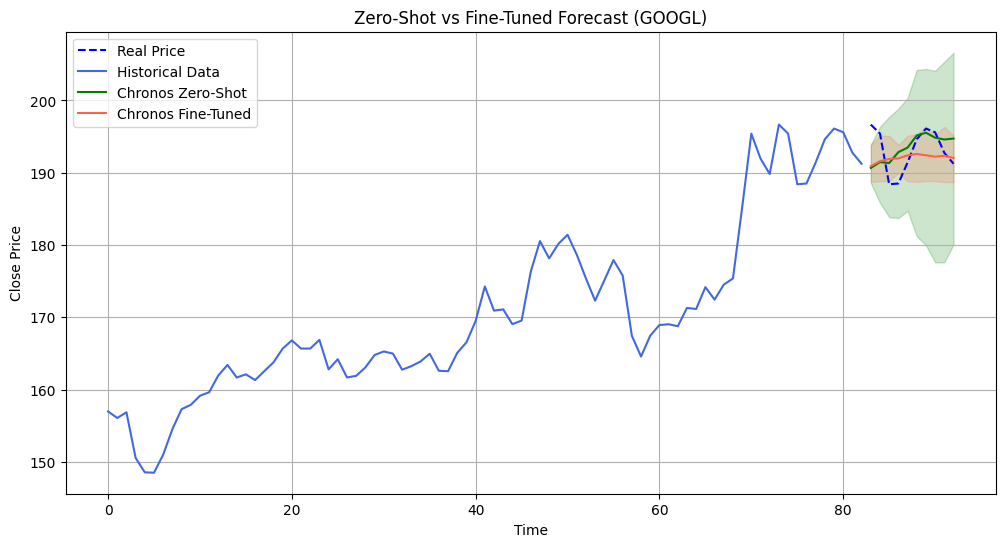


PERFORMANCE METRICS:
                          MSE      RMSE      MAPE      MASE
Chronos Zero-Shot    9.487050  3.080106  1.330509  1.174435
Chronos Fine-Tuned  11.133874  3.336746  1.541814  1.362758
SCALING PERFORMANCE (Fine-Tuned vs Zero-Shot):
MSE     1.173586
RMSE    1.083322
MAPE    1.158815
MASE    1.160352
dtype: float64


<ipython-input-9-8a243eab4cfa>:41: FutureWarning: using <function gmean at 0x7f306e7996c0> in Series.agg cannot aggregate and has been deprecated. Use Series.transform to keep behavior unchanged.
  return relative_score.agg(gmean)  # Geometric mean of improvements


In [42]:
# Chronos model (Zero-Shot)
zero_shot_pipeline = BaseChronosPipeline.from_pretrained("amazon/chronos-t5-tiny", device_map="cuda", torch_dtype=torch.bfloat16)

# Fine-tuned Chronos model
fine_tuned_pipeline = ChronosPipeline.from_pretrained("finetuned_model")

prediction_length = 10  # Forecasting horizon
symbols = ["AAPL", "GOOGL"]

for symbol in symbols:
    print(f"----------- {symbol} -----------")

    # Download financial data from Yahoo Finance
    data = yf.download(symbol, start="2024-09-01", end="2024-12-31", progress=False)

    # Extract the closing prices
    df = data.reset_index()
    close_prices = df["Close"].values.reshape(-1)

    # Zero-Shot
    forecast_zero_shot = zero_shot_pipeline.predict(context=torch.tensor(close_prices), prediction_length=prediction_length)

    # Fine-Tuned
    forecast_fine_tuned = fine_tuned_pipeline.predict(context=torch.tensor(close_prices), prediction_length=prediction_length)

    # Compute statistics for both models
    low_zero, median_zero, high_zero, mean_zero, var_zero = get_forecast_stats(forecast_zero_shot[0])
    low_fine, median_fine, high_fine, mean_fine, var_fine = get_forecast_stats(forecast_fine_tuned[0])

    print(f'Variance (Zero-Shot): {var_zero}')
    print(f'Variance (Fine-Tuned): {var_fine}')

    # Plot the forecast comparison
    forecast_index = range(len(close_prices), len(close_prices) + prediction_length)
    plt.figure(figsize=(12, 6))

    plt.plot(forecast_index, close_prices[-prediction_length:], color="blue", linestyle="--", label="Real Price")
    plt.plot(close_prices, color="royalblue", label="Historical Data")
    plt.plot(forecast_index, mean_zero, color="green", label="Chronos Zero-Shot")
    plt.fill_between(forecast_index, low_zero, high_zero, color="green", alpha=0.2)
    plt.plot(forecast_index, mean_fine, color="tomato", label="Chronos Fine-Tuned")
    plt.fill_between(forecast_index, low_fine, high_fine, color="tomato", alpha=0.2)
    plt.title(f"Zero-Shot vs Fine-Tuned Forecast ({symbol})")
    plt.xlabel("Time")
    plt.ylabel("Close Price")
    plt.legend()
    plt.grid()
    plt.show()
    plt.close()

    # ----- Comparison of performance metrics -----

    # Zero-Shot (use mean of the predicted distribution)
    forecast_zero_shot = zero_shot_pipeline.predict(context=torch.tensor(close_prices), prediction_length=prediction_length)[0].numpy().mean(axis=0)

    # Fine-Tuned (use mean of the predicted distribution)
    forecast_fine_tuned = fine_tuned_pipeline.predict(context=torch.tensor(close_prices), prediction_length=prediction_length)[0].numpy().mean(axis=0)

    # Use real values for comparison
    actual_values = close_prices[-prediction_length:]

    # Numerical results for both models
    metrics_zero_shot = compute_metrics(actual_values, forecast_zero_shot, close_prices[:-prediction_length])
    metrics_fine_tuned = compute_metrics(actual_values, forecast_fine_tuned, close_prices[:-prediction_length])

    # Create a DataFrame for comparison
    results_df = pd.DataFrame([metrics_zero_shot, metrics_fine_tuned], index=["Chronos Zero-Shot", "Chronos Fine-Tuned"])

    # Comparison between Fine-Tuned and Zero-Shot models
    relative_scores = agg_relative_score(results_df.loc["Chronos Fine-Tuned"], results_df.loc["Chronos Zero-Shot"])

    # Output the results
    print("\nPERFORMANCE METRICS:")
    print(results_df)
    print("SCALING PERFORMANCE (Fine-Tuned vs Zero-Shot):")
    print(relative_scores)